# Machine Learning Lab 3: Analysis of Airbnb data using Clustering, Classification, and Regression

By: William Arnost, Stephen Johnson, Sean Kennedy, Tazeb Abera

# Business Understanding 1	10	
## Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

Airbnb is a room sharing platform. Hosts can share space they are not using and guests can rent the space when they need a place to stay. Hosts and Guests are brought together on airbnb.com, where they can review available listings in the area of their choice, as well as other travel offerings. Airbnb offers protection to hosts in case of damage to their property, and guests can benefit from the ratings left by other guests. 

Airbnb markets itself as a disruptor of the hotel industry, offering guests more choices and often cheaper prices in the places they live and visit. It is part of the sharing economy, allowing hosts to monetize rooms that are temporarily unoccupied. Opponents criticize the lack of guest protection typically provided by hotel regulation and negative impacts on communities from the constant stream of guests. 

The website http://insideairbnb.com/ is dedicated to analyzing the impact of airbnb on communities. They scraped listing data from Airbnb's website, which was then posted to Kaggle by the user Dgomonov who lists themselves as a student at Drexel University in their profile. The purpose of the data is to help understand how airbnb hosts are doing business and how that effects communities. Are hosts just sharing space temporarily or are they setting up long term rentals? Are hosts sharing space in their homes or do they have multiple properties, which would imply they are running a business. More information about their analysis goals can be found here http://insideairbnb.com/about.html.

While we sourced our data from Kaggle, user Dgomonov sourced it from insideairbnb.com, you can find it here: http://insideairbnb.com/get-the-data.html. Data is available for many locales, not just New York City. The about page cited in the previous paragraph also has a disclaimers section, which states they are not associated with airbnb or competitors, among other important disclosures. Worth mentioning here is that the data quality is not guaranteed, however they do exercise care in collecting it. All data was publicly available when it was collected, and no "private" data was used. There are many other useful disclosures on that page. 

This data set we used for this project includes listings in the New York City area during 2019 and was sourced from the following Kaggle site: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data. 

### How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

We want to evaluate whether or not clustering can improve the predictions of room type and price. The goal is to discretize some of our model inputs in a data driven way in a search for meaningful relationships. Those clusters will be considered beneficial if they improve the accuracy of the model or the stability of the results (measured by the standard deviation of the accuracy metric). There may not always be a model that is both more accurate and less variable, so we may need to make a trade off between the two.

For model evaluation, the accuracy metric we use will depend on the task. When we are predicting room type, we will use accuracy. When we are predicting price, we will use Negative Mean Square Error. 

For room type, we have a binary classification problem. We are predicting if an airbnb listing is for an entire apartment or a private room. These classes are fairly balanced, so we are choosing accuracy as our primary metric. 

For price, we have a continuous value to predict. Our accuracy can't be measured as right and wrong. Accuracy is based on how close a predicted value is to actual. Mean Squared Error (MSE) takes the average of the squared distances our estimates are from the actual values. Squaring the distances makes sure our negative errors don't cancel our positive errors. The reason we are using the negative of MSE is because we are using sklearn's gridsearchcv to build our models, and it prefers to maximize metrics, rather than minimize them. We could have used RMSE, which would have put the metric on the same scale as the dependent variable, but we will be standardizing that value anyway so we don't feel this would add much to interpretability. MAPE can't be used because we have zeros in our data (from standardization) that would prevent its calculation.


Reference: https://www.sciencedirect.com/science/article/abs/pii/S0167865508002687
https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/
https://www.dataquest.io/blog/machine-learning-tutorial/

# Data Understanding 1	10	
## Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

### Package Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, SpectralClustering
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.sparse.linalg import eigsh
from yellowbrick.classifier import ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ClassificationReport, ClassPredictionError, ROCAUC
from yellowbrick.target import ClassBalance
from scipy.sparse.linalg import eigsh

### Helper Functions

In [3]:
random_state = 5
def is_sig_diff(lower, upper):
    if upper > 0:
        return True if lower > 0 else False # interval contains 0
    if upper < 0:
        return True if lower < 0 else False # interval contains 0
    
def compare_distributions(acc1, acc2):
    t = 2.26 / np.sqrt(len(acc1))

    e = acc1-acc2
    # std1 = np.std(acc1)
    # std2 = np.std(acc2)
    stdtot = np.std(e)

    dbar = np.mean(e)
    #print ('Range of:', dbar-t*stdtot,dbar+t*stdtot)
    #print (np.mean(acc1), np.mean(acc2))
    upper =  dbar+t*stdtot
    lower = dbar-t*stdtot
    return {
        'lower':  lower,
        'upper':  upper,
        'mean_1': np.mean(acc1),
        'mean_2': np.mean(acc2),
        'significant': is_sig_diff(lower, upper)
    }

def transform_data(data):
    #OH encode
    label_encode = [
        x for x, y in dict(data.dtypes).items()
        if type(y) == pd.CategoricalDtype
    ]
    for var in label_encode:
        #impute to Mode
        print(f"{var} was OHE'd")
        data[var].fillna(data[var].mode()[0], inplace=True)
        cat_list = pd.get_dummies(data[var], prefix=var)
        data_new = data.join(cat_list)
        data = data_new

    normalize = [x for x, y in dict(data.dtypes).items() if y == np.float64]
    for col in normalize:
        #change impution scheme?
        print(f"{col} was Standard Scaled")
        data[col].fillna(data[col].median(), inplace=True)
        normalizer = StandardScaler()
        ar_train = data[col].to_numpy().reshape(-1, 1)
        normalizer.fit(ar_train)
        data.loc[:, col] = normalizer.transform(ar_train)
    
    data.drop(columns=label_encode, inplace=True)
    #data.drop(columns=target_col, inplace=True)
    
    return data

def run_spectral_clustering(train
                           , cols=['longitude', 'latitude']
                           , clusters=[5]
                           , affinity_types=['nearest_neighbors']
                           , eigen_solvers=['arpack']
                           , show_map=True):

    assert(len(cols) == 2)
    results = {}
    for n_clusters in clusters:
            for affinity_type in affinity_types:
                for solver in eigen_solvers:
                    X = train[cols].copy()
                    spc = SpectralClustering(n_clusters=n_clusters
                                             , affinity = affinity_type
                                             , random_state=random_state
                                            , n_jobs=-1
                                            , eigen_solver=solver)
                    spec_fit = spc.fit(X)
                    new_feature = spc.labels_
                    y = y_train.values.ravel() # target 
                    X = X_train.drop(columns=cols) #drop the cols that we are using for clustering  
                    X = np.column_stack((X, pd.get_dummies(new_feature))) # new feature set
                    acc = cross_val_score(classifier
                                          ,X 
                                          ,y=y
                                          ,cv=cv)
                    results.update({(affinity_type, n_clusters, solver):{
                                        'cluster': spc,
                                        'solver': solver,
                                        'spec_fit':spec_fit,
                                        'xform_data':X,
                                        'target': y,
                                        'results':acc,
                                        'clusters':n_clusters}
                                   })
                    if show_map:
                        plt.scatter(X_train[cols[0]]
                                    , X_train[cols[1]]
                                    , c=new_feature
                                    , cmap=plt.cm.rainbow
                                    , s=5
                                    , linewidths=0)
                        print (f'Average accuracy = {acc.mean()*100}+-{acc.std()*100}')
                        plt.title(f'Affinity Matrix Type: {affinity_type} Clusters:{n_clusters} Cols:{cols}')
                        plt.show()
    return results 
                    
def generate_color_map(series):
    return {y:x for x,y in enumerate(series.unique())}

def analyze_eigen_values(matrix, title='', eigen_vectors=10):
    eig_vals, eig_vecs = eigsh(matrix, k=eigen_vectors)
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort()
    eig_pairs.reverse()

    # Visually confirm that the list is correctly sorted by decreasing eigenvalues
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    x=['PC %s' %i for i in range(0,len(eig_vals))]
    data = {
        'variance_explained':var_exp, 
        'cum_var_explained':cum_var_exp,
        'eigen_values': eig_vals,
        'eig_vecs':eig_vecs,
        'eig_pairs':eig_pairs,
        'index':x}
    data_frame = pd.DataFrame({
        'variance_explained':data['variance_explained'],
        'cum_var_explained':data['cum_var_explained'],
        'index':data['index']
    })
    plt.show(sns.barplot(x='variance_explained', y='index', data=data_frame).set_title(f'Explained Variance {title}'))
    plt.show(sns.barplot(x='cum_var_explained', y='index', data=data_frame).set_title(f'Cumulative Variance {title}'))
    return data

### Import Data

In [4]:
data = pd.read_csv('ABNB_NY_V2.csv')
summary = data.describe()
print({x: len(data[x].unique()) for x in data.columns})
summary

{'id': 48895, 'name': 47897, 'host_id': 37457, 'host_name': 11453, 'neighbourhood_group': 5, 'neighbourhood': 221, 'latitude': 19048, 'longitude': 14718, 'room_type': 3, 'price': 674, 'minimum_nights': 109, 'number_of_reviews': 394, 'last_review': 1765, 'reviews_per_month': 938, 'calculated_host_listings_count': 47, 'availability_365': 366, 'ZIP': 199, 'dist_subway': 46157, 'cnt_all': 133, 'cnt_entire_home': 95, 'cnt_private_room': 74, 'cnt_shared_room': 14, 'avgprice_all': 1912, 'avgprice_entire_home': 1409, 'avgprice_private_room': 1309, 'avgprice_shared_room': 219}


id       host_id      latitude     longitude         price  \
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000  48895.000000   
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170    152.720687   
std    1.098311e+07  7.861097e+07      0.054530      0.046157    240.154170   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070     69.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680    106.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    48895.000000       48895.000000       38843.000000   
mean         7.029962          23.274466           1.373221   
std         20.510550          44.550582           1.680442   
min          1.000000           0.000000           0.010000   
25%          1.000000           1.000000           0.190000   
50%          3.000000           5.000000           0.720000   
75%          5.000000          24.000000           2.020000   
max       1250.000000         629.000000          58.500000   

       calculated_host_listings_count  availability_365           ZIP  \
count                    48895.000000      48895.000000  48871.000000   
mean                         7.143982        112.781327  10675.111211   
std                         32.952519        131.622289    599.591915   
min                          1.000000          0.000000  10001.000000   
25%                          1.000000          0.000000  10024.000000   
50%                          1.000000         45.000000  11104.000000   
75%                          2.000000        227.000000  11221.000000   
max                        327.000000        365.000000  11697.000000   

        dist_subway       cnt_all  cnt_entire_home  cnt_private_room  \
count  48895.000000  48895.000000     48895.000000      48895.000000   
mean       0.245997     52.815768        29.719726         22.013396   
std        0.346640     43.303548        29.254144         18.668278   
min        0.000553      0.000000         0.000000          0.000000   
25%        0.103457     20.000000         8.000000          7.000000   
50%        0.173022     43.000000        20.000000         17.000000   
75%        0.269066     73.000000        42.000000         33.000000   
max        4.931115    230.000000       142.000000         91.000000   

       cnt_shared_room  avgprice_all  avgprice_entire_home  \
count     48895.000000  48895.000000          48895.000000   
mean          1.082646    152.703409            191.493067   
std           2.615105     90.678742            114.468382   
min           0.000000      0.000000              0.000000   
25%           0.000000     94.812500            137.250000   
50%           0.000000    135.208333            180.850000   
75%           1.000000    189.000000            231.264463   
max          26.000000   5000.000000           5000.000000   

       avgprice_private_room  avgprice_shared_room  
count           48895.000000          48895.000000  
mean               98.024409             40.581520  
std                73.981026             93.479089  
min                 0.000000              0.000000  
25%                64.500000              0.000000  
50%                83.666667              0.000000  
75%               111.500000             60.000000  
max              3000.000000           1800.000000

The data set contains a total of 48,894 records and 29 attributes or features. The latitude, longitude, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, availability_365, dist_subway, cnt_all, cnt_entire_home, cnt_private_room, cnt_shared_room, avgpric_all, avgprice_entire_home, avgprice_private_room, avgprice_shared_room, and days_since_last_review features are float type. The id, room_type_num, and Response features are integer type. Finally, neighborhood_group, room_type, and ZIP are category type.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

Some of the variable types will need to be fixed, we will perform data cleaning in the following sections.

### Type Conversion

All features have been converted to float type. Categorical features will be converted to numeric type in subsequent data steps in the modeling process.

In [6]:
data['price'] = data['price'].astype('float')
data['minimum_nights'] = data['minimum_nights'].astype('float')
data['number_of_reviews'] = data['number_of_reviews'].astype('float')
data['calculated_host_listings_count'] = data[
    'calculated_host_listings_count'].astype('float')
data['availability_365'] = data['availability_365'].astype('float')
data['dist_subway'] = data['dist_subway'].astype('float')
data['cnt_all'] = data['cnt_all'].astype('float')
data['cnt_all'] = data['cnt_all'].astype('float')
data['cnt_entire_home'] = data['cnt_entire_home'].astype('float')
data['cnt_private_room'] = data['cnt_private_room'].astype('float')
data['cnt_shared_room'] = data['cnt_shared_room'].astype('float')
data['avgprice_all'] = data['avgprice_all'].astype('float')
data['avgprice_entire_home'] = data['avgprice_entire_home'].astype('float')
data['avgprice_private_room'] = data['avgprice_private_room'].astype('float')
data['avgprice_shared_room'] = data['avgprice_shared_room'].astype('float')
data['neighbourhood_group'] = data['neighbourhood_group'].astype('category')
data['neighbourhood_group'] = data['neighbourhood_group'].astype('category')
data['room_type'] = data['room_type'].astype('category')
data['ZIP'] = data['ZIP'].astype('category')
data['last_review'] = pd.to_datetime(data['last_review'])

data['days_since_last_review'] = (
    dt.datetime.strptime('2020-01-01', '%Y-%m-%d') -
    data['last_review']).dt.days
data.days_since_last_review.fillna(data.days_since_last_review.max(),
                                   inplace=True)
data.drop(columns=['last_review'], inplace=True)

target_col = 'room_type'
room_types = {'Entire home/apt': 0, 'Private room': 1, 'Shared room': 2}
data['room_type_num'] = data.apply(lambda x: room_types[x.room_type], axis=1)
data['Response'] = data.apply(lambda x: room_types[x.room_type], axis=1)

### Missing Data

In [7]:
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
ZIP                                  24
dist_subway                           0
cnt_all                               0
cnt_entire_home                       0
cnt_private_room                      0
cnt_shared_room                       0
avgprice_all                          0
avgprice_entire_home                  0
avgprice_private_room                 0
avgprice_shared_room                  0


The table above gives us a count of the missing values in each of our data fields. 

Last review and reviews per month have a significant amount of missing data. These missing values likely indicate there are no reviews for these particular listings. There are a variety of missing imputation strategies, we would want to be careful since imputing a value here would tell the model the listing has reviews, when the fact that there are no reviews could be valuable information. In a normal regression model, a zero imputation might be useful because it would remove the effect of this feature. We could also include a dummy variable to indicate if this feature is missing, which would help us tell if the model gains information from knowing there are no reviews.

The other features with missing values are name and host_name. This is likely because they were not provided by the host, or the data collector was unable to retrieve it from the page. It does not make sense to impute these. We have host_id, with no missing, to identify unique hosts. In most cases that would make name and host_name redundant. If for some reason we do need them, we could try to repair them by checking if that host has any other listings with those variables populated, using host_id. Otherwise, we'd likely give them an empty label.

### Duplicate Data

In [8]:
airbnbDups = data[data.duplicated()]
airbnbDups.head()

Empty DataFrame
Columns: [id, name, host_id, host_name, neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, availability_365, ZIP, dist_subway, cnt_all, cnt_entire_home, cnt_private_room, cnt_shared_room, avgprice_all, avgprice_entire_home, avgprice_private_room, avgprice_shared_room, days_since_last_review, room_type_num, Response]
Index: []

[0 rows x 28 columns]

There are no duplicate rows in the data, based on the check above.

### Check for Outliers

In [9]:
data.drop(columns=['host_id','id']).describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])

latitude     longitude         price  minimum_nights  \
count  48895.000000  48895.000000  48895.000000    48895.000000   
mean      40.728949    -73.952170    152.720687        7.029962   
std        0.054530      0.046157    240.154170       20.510550   
min       40.499790    -74.244420      0.000000        1.000000   
1%        40.596687    -74.026774     30.000000        1.000000   
5%        40.646114    -74.003880     40.000000        1.000000   
25%       40.690100    -73.983070     69.000000        1.000000   
50%       40.723070    -73.955680    106.000000        3.000000   
75%       40.763115    -73.936275    175.000000        5.000000   
95%       40.825643    -73.865771    355.000000       30.000000   
99%       40.864661    -73.776920    799.000000       45.000000   
max       40.913060    -73.712990  10000.000000     1250.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       48895.000000       38843.000000                    48895.000000   
mean           23.274466           1.373221                        7.143982   
std            44.550582           1.680442                       32.952519   
min             0.000000           0.010000                        1.000000   
1%              0.000000           0.020000                        1.000000   
5%              0.000000           0.040000                        1.000000   
25%             1.000000           0.190000                        1.000000   
50%             5.000000           0.720000                        1.000000   
75%            24.000000           2.020000                        2.000000   
95%           114.000000           4.640000                       15.000000   
99%           214.000000           7.195800                      232.000000   
max           629.000000          58.500000                      327.000000   

       availability_365   dist_subway       cnt_all  cnt_entire_home  \
count      48895.000000  48895.000000  48895.000000     48895.000000   
mean         112.781327      0.245997     52.815768        29.719726   
std          131.622289      0.346640     43.303548        29.254144   
min            0.000000      0.000553      0.000000         0.000000   
1%             0.000000      0.012688      1.000000         0.000000   
5%             0.000000      0.035655      3.000000         1.000000   
25%            0.000000      0.103457     20.000000         8.000000   
50%           45.000000      0.173022     43.000000        20.000000   
75%          227.000000      0.269066     73.000000        42.000000   
95%          359.000000      0.571232    145.000000        98.000000   
99%          365.000000      2.036830    182.000000       129.000000   
max          365.000000      4.931115    230.000000       142.000000   

       cnt_private_room  cnt_shared_room  avgprice_all  avgprice_entire_home  \
count      48895.000000     48895.000000  48895.000000          48895.000000   
mean          22.013396         1.082646    152.703409            191.493067   
std           18.668278         2.615105     90.678742            114.468382   
min            0.000000         0.000000      0.000000              0.000000   
1%             0.000000         0.000000     43.333333              0.000000   
5%             1.000000         0.000000     64.500000             70.000000   
25%            7.000000         0.000000     94.812500            137.250000   
50%           17.000000         0.000000    135.208333            180.850000   
75%           33.000000         1.000000    189.000000            231.264463   
95%           59.000000         4.000000    284.046053            330.960000   
99%           73.000000        13.000000    426.758621            519.933333   
max           91.000000        26.000000   5000.000000           5000.000000   

       avgprice_private_room  avgprice_shared_room  days_since_last_review  \
count           48895.000000          48895.000000     

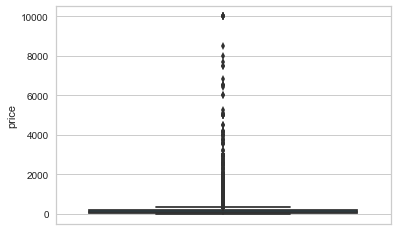

In [10]:
sns.boxplot(y='price', data=data)

Price is one of our target variables, and it is very skewed. We have some properties that looks like long term leases that may be stating their price on a different time period than nightly, we will remove the rows with price greater than 300.

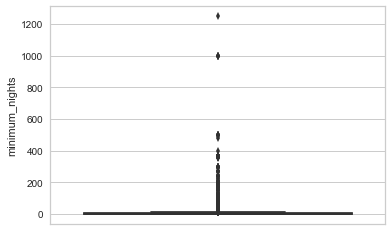

In [11]:
sns.boxplot(y='minimum_nights', data=data)

Most airbnbs would be expected to have a minimum stay of 1-3 nights. Anything 20 nights or greater suggests a long term lease, which is different from most of our listings. 

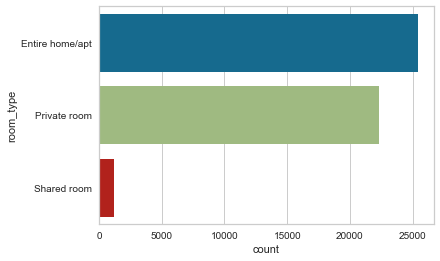

In [12]:
sns.countplot(y='room_type', data=data)

For classification, we will remove shared room since it has such a small sample compared to the other classes. 

### Remove Outliers

Units with price listed as 0 and greater than 300 were removed. Additionally, units with minimum nights greater than 20 were removed. We will remove shared room in the extra work section where we do classification.

In [13]:
data = data[data.price != 0].copy()
data = data[data.price < 300].copy()
data = data[data.minimum_nights <= 20].copy()

### Drop Columns that won't be used in modeling

In [14]:
data.drop(
    columns=['id', 'name', 'host_id', 'host_name','ZIP','neighbourhood'],
    inplace=True)

### OHE and Standard Scaling

During the training process, missing values would result in errors with Scikit learn if not removed or imputed. These missing values were imputed using the non-missing values in each feature. For categorical variables, mode imputation was applied. For float variables, median imputation was applied.  

Multiple features in the data set contain values with different ranges. Features with higher ranges and larger values could have a greater influence on the result. This was accounted for through normalization using Standard Scaler. In this case, normalization is achieved by simply converting values to z-scores for all numeric features.

In [15]:
data2 = transform_data(data)

neighbourhood_group was OHE'd
room_type was OHE'd
latitude was Standard Scaled
longitude was Standard Scaled
price was Standard Scaled
minimum_nights was Standard Scaled
number_of_reviews was Standard Scaled
reviews_per_month was Standard Scaled
calculated_host_listings_count was Standard Scaled
availability_365 was Standard Scaled
dist_subway was Standard Scaled
cnt_all was Standard Scaled
cnt_entire_home was Standard Scaled
cnt_private_room was Standard Scaled
cnt_shared_room was Standard Scaled
avgprice_all was Standard Scaled
avgprice_entire_home was Standard Scaled
avgprice_private_room was Standard Scaled
avgprice_shared_room was Standard Scaled
days_since_last_review was Standard Scaled


### Final Data

In [16]:
data_final = data2
data_final.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40180 entries, 0 to 48894
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   latitude                           40180 non-null  float64
 1   longitude                          40180 non-null  float64
 2   price                              40180 non-null  float64
 3   minimum_nights                     40180 non-null  float64
 4   number_of_reviews                  40180 non-null  float64
 5   reviews_per_month                  40180 non-null  float64
 6   calculated_host_listings_count     40180 non-null  float64
 7   availability_365                   40180 non-null  float64
 8   dist_subway                        40180 non-null  float64
 9   cnt_all                            40180 non-null  float64
 10  cnt_entire_home                    40180 non-null  float64
 11  cnt_private_room                   40180 non-null  flo

The final data set contains a total of 40,180 records and 28 attributes or features. Float type features include latitude, longitude, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, availability_365, dist_subway, cnt_all, cnt_entire_home, cnt_private_room, cnt_shared_room, avgprice_all, avgprice_entire_home, avgprice_private_room, avgprice_shared_room, and days_since_last_review. 

The response feature is integer type and was reclassified from room_type to represent a binary feature of 1 for private room and 0 for entire home/apartment (2 is shared room and will be removed for the classification task). The neighbourhood_group feature contains 5 unique categorical values that were transformed through one-hot encoding. This process is used to re-classify a single categorical feature into multiple binary features. In the ‘neighbourhood_group’ feature, the values for Bronx, Brooklyn, Manhattan, Queens, and Staten Island were converted to individual binary features with a value of 1 being used to identify that the rental unit is located in each particular neighborhood or borough designated by the feature.

Several features were added in the first stage of the project. These features were added to provide further insight into the relationships between location, activity, supply and price. These include dist_subway, cnt_all, cnt_entire_home, cnt_private_room, cnt_shared_room, avgprice_entire_home, avgprice_private_room, and avgprice_shared_room. The features with names starting with 'cnt_' represent the count of listings for each room type within close proximity. Additionally, the features with names starting with 'avgprice_' represent the average price of listings within close proximity.

Some features were removed for not adding value to the project. These include id, name, host_id, host_name, neighbourhood, and ZIP. 

During the training process, missing values would result in errors with Scikit learn if not removed or imputed. These missing values were imputed using the non-missing values in each feature. For categorical variables, mode imputation was applied. For float variables, median imputation was applied.  

Multiple features in the data set contain values with different ranges. Features with higher ranges and larger values could have a greater influence on the result. This was accounted for through normalization using Standard Scaler. In this case, normalization is achieved by simply converting values to z-scores for all numeric features.

In our cleaned dataset: All features have been converted to numeric values since we can’t calculate the Euclidean distance of a value with non-numeric characters. Non-numeric and not useful features have been removed for simplicity. Any listings with missing values have been imputed or removed. Also, we have normalized the features to provide more accurate results.

Here is a list of the original features from the data set (includes modified features): 

* latitude and longitude: geo-location or coordinate of the rental 
* price: nightly price for the rental   
* minimum_nights: minimum number of nights a guest can stay for the rental
* number_of_reviews: number of reviews that previous guests have left
* calculated_host_listings_count: number of listings by host
* availability_365: reference to whether the listing is available all year  
* days_since_last_review: number of days since last review was placed  
* response: room type feature used as response variable (0-entire home/apt, 1-private room)
* neighbourhood_group_Bronx: identifies whether unit is located in neighbourhood (0-no, 1-yes)
* neighbourhood_group_Brooklyn: identifies whether unit is located in neighbourhood (0-no, 1-yes)
* neighbourhood_group_Manhattan: identifies whether unit is located in neighbourhood (0-no, 1-yes)
* neighbourhood_group_Queens: identifies whether unit is located in neighbourhood (0-no, 1-yes)
* neighbourhood_group_Staten Island: identifies whether unit is located in neighbourhood (0-no, 1-yes)

Here is a list of features that were added to the data set:

* dist_subway: distance to nearest subway    
* cnt_all: total number of rental units within 1M sqft of area
* cnt_entire_home: total number of units (entire home/apt) within 1M sqft of area
* cnt_private_room: total number of rental units (private room) within 1M sqft of area
* cnt_shared_room: total number of rental units (shared room) within 1M sqft of area
* avgprice_all: average price of all rental units within 1M sqft of area
* avgprice_entire_home: average price of rental units (entire home/apt) within 1M sqft of area
* avgprice_private_room: average price of rental units (private room) within 1M sqft of area
* avgprice_shared_room: average price of rental units (shared room) within 1M sqft of area
* room_type_num is a binary version of room type for the regression problem, it is identical to response.

# Data Understanding 2	10	
## Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

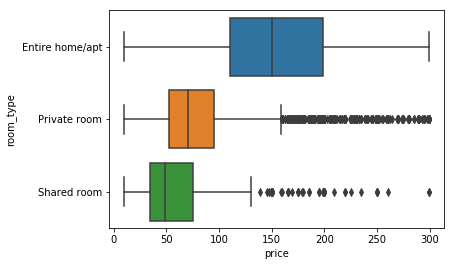

In [12]:
sns.boxplot(x="price", y="room_type", data=data)

The following boxplot represents price between the 3 unique values for room type. As mentioned earlier, only entire home/apartment and shared room are being used for prediction. According to the boxplot, the median value of price for entire home/apartment is around 150/night compared with around 70/night for private room. Listings are priced between 200-300 in the top 25% for entire home/apartment and 90-160 for private room. Listings are priced between 20-110 in the bottom 25% for entire home/apartment and 20-50 for private room. Price for shared room listings appear to be 20-30% lower than private room listings.

(-74.27207572939068, -73.68533427060933, 40.47745707395144, 40.93539292604856)

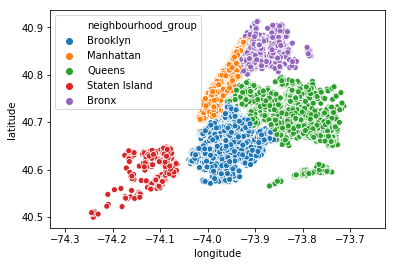

In [13]:
sns.scatterplot(x='longitude',y='latitude',hue='neighbourhood_group', data=data)
plt.axis('equal')

Price will vary by proximity to points of interest and important amenities. This scatter plot shows latitude, longitude, and neighborhood group which are factors in our models.

In [232]:
#Mapping References
#https://python-visualization.github.io/folium/quickstart.html
#https://python-visualization.github.io/folium/plugins.html


In [17]:
m = folium.Map(location=[data.latitude.mean(), data.longitude.mean()],
    tiles='Stamen Toner',
    zoom_start=11)
HeatMap(data[['latitude','longitude','price']],radius=8).add_to(m)
m

This plot shows a heatmap of price. Red is a higher price and blue is a lower price. The map overlat helps with identifying important features like airports and parks.

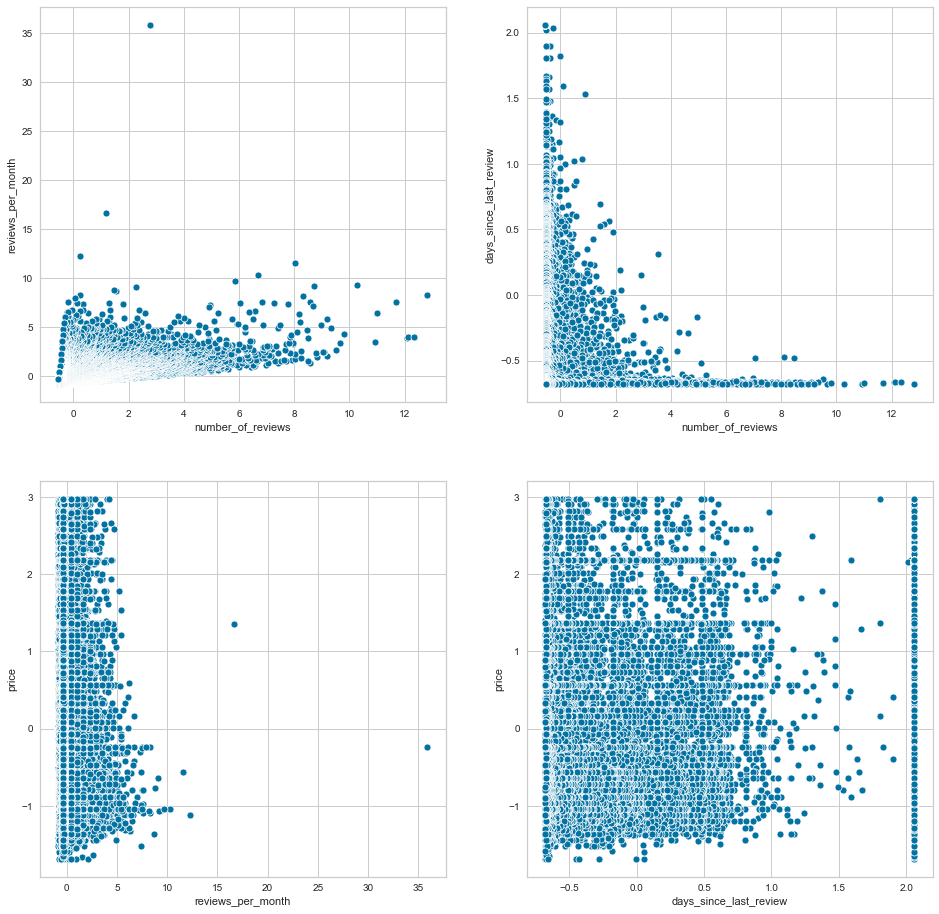

In [245]:
fig, axs = plt.subplots(ncols=2, nrows=2,figsize=[16,16])
sns.scatterplot(y='reviews_per_month',x='number_of_reviews', data=data_final, ax=axs[0,0])
sns.scatterplot(y='days_since_last_review',x='number_of_reviews', data=data_final, ax=axs[0,1])
sns.scatterplot(y='price',x='reviews_per_month', data=data_final, ax=axs[1,0])
sns.scatterplot(y='price',x='days_since_last_review', data=data_final, ax=axs[1,1])

We plan to investigate reviews as part of our clustering. There is no obvious relationship with price here, which we find odd since we would expect customers to prefer higher rated listings, which could then demand a higher price. We will see if clustering can help connect reviews with price.

# Modeling and Evaluation 1	10	
## Train and adjust parameters

In [16]:
data_final.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40180 entries, 0 to 48894
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   latitude                           40180 non-null  float64
 1   longitude                          40180 non-null  float64
 2   price                              40180 non-null  float64
 3   minimum_nights                     40180 non-null  float64
 4   number_of_reviews                  40180 non-null  float64
 5   reviews_per_month                  40180 non-null  float64
 6   calculated_host_listings_count     40180 non-null  float64
 7   availability_365                   40180 non-null  float64
 8   dist_subway                        40180 non-null  float64
 9   cnt_all                            40180 non-null  float64
 10  cnt_entire_home                    40180 non-null  float64
 11  cnt_private_room                   40180 non-null  flo

## Setup

In [197]:
features, target = data_final.drop(
    columns=['price','room_type_num','Response']), data_final.loc[:, ['price']]
features.shape, target.shape

cv = KFold(n_splits=10)
scoring='neg_mean_squared_error'
n_jobs=4

Splitting the dataset, dropping room_type_num bercause it is redundant, Response because that is for classification, and price because that is our target.

## Baseline Model

In [155]:
%%time

rf_Regressor = RandomForestRegressor(
    n_estimators = 200,
    random_state=0,
    criterion='mse',
    n_jobs=n_jobs)

nmse_base = cross_val_score(rf_Regressor, features, y=target.values.ravel(), cv=cv,  scoring=scoring,n_jobs=n_jobs)
print ("Average Neg. MSE = ", nmse.mean(), "+-", nmse.std())
param_base = ['Base_Model',nmse.mean(),nmse.std()]

Average Neg. MSE =  -0.4148422597322945 +- 0.03148309087544601
Wall time: 1min 6s


This is our baseline model, it has an negative mean square error of -0.41 +- 0.0302. It is good to remember the price has been normalized, which is why the scale may seem strange.

## K Means of Latitude and Longitude

Location is a key factor in price. The location variables in our data set are latitude, longitude, and neighborhood_group. Latitude and longitude are continuous where neighborhood_group is categorical and has been split into 5 indicator variables. We start by clustering on latitude and longitude, but when we test the clustering in the model we will remove all location variables. Even though neighborhood_group isn't part of the clustering, those neighborhoods have clear geographic boundries that are correlated to latitude and longitude.

In [25]:
%%time

X1 = features[['latitude','longitude']]
cls = KMeans(n_clusters=5, init='k-means++',random_state=1,n_jobs=n_jobs)
cls.fit(X1)
newfeature = cls.labels_

X = features.drop(columns=['neighbourhood_group_Staten Island','neighbourhood_group_Bronx','neighbourhood_group_Manhattan',
                          'neighbourhood_group_Queens','neighbourhood_group_Brooklyn','latitude','longitude'])
X = np.column_stack((X,pd.get_dummies(newfeature)))

nmse_base = cross_val_score(rf_Regressor, X, y=target.values.ravel(), cv=cv,  scoring=scoring, n_jobs=n_jobs)

print ("Average Neg. MSE (with kmeans for latitude/longitutde)= ", nmse.mean(), "+-", nmse.std())

#Reference:https://github.com/jakemdrew/DataMiningNotebooks/blob/master/09.%20Clustering%20and%20Discretization.ipynb

Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.41282613970645565 +- 0.030872973284814493
Wall time: 55.6 s


Here we run a basic K means clustering then add dummy variables representing the clusters to our feature set for modeling. We also removed the location based variables before running the model. We see some accuracy improvement but the standard deviation of accuracy in cross validation also increased.

In [26]:
%%time
X = features.drop(columns=['latitude','longitude'])
X = np.column_stack((X,pd.get_dummies(newfeature)))

nmse = cross_val_score(rf_Regressor, X, y=target.values.ravel(), cv=cv,  scoring=scoring,n_jobs=n_jobs)

print ("Average Neg. MSE (with kmeans for latitude/longitutde w/ neighborhood)= ", nmse.mean(), "+-", nmse.std())

Average Neg. MSE (with kmeans for latitude/longitutde w/ neighborhood)=  -0.4130587734900897 +- 0.030768980136585
Wall time: 55.4 s


Here I wanted to run a test to see if keeping neighborhood group would be helpful, but it did not improve accuracy over the random forest that excluded it. Likely it is correlated with our clusters.

## K Means Clustering of Review Variables

In [209]:
%%time
X2 = features[['number_of_reviews','days_since_last_review','reviews_per_month']]
cls = KMeans(n_clusters=5, init='k-means++',random_state=1,n_jobs=n_jobs)
cls.fit(X2)
newfeature = cls.labels_

X = features.drop(columns=['number_of_reviews','days_since_last_review','reviews_per_month'])
X = np.column_stack((X,pd.get_dummies(newfeature)))

nmse = cross_val_score(rf_Regressor, X, y=target.values.ravel(), cv=cv,  scoring=scoring, n_jobs=n_jobs)

print ("Average Neg. MSE (with kmeans for review variables)= ", nmse.mean(), "+-", nmse.std())
review_labs=newfeature

#Reference:https://github.com/jakemdrew/DataMiningNotebooks/blob/master/09.%20Clustering%20and%20Discretization.ipynb

Average Neg. MSE (with kmeans for review variables)=  -0.42911786791645445 +- 0.027964014303713935
Wall time: 1min


Here we are clustering on 3 review based variables. Perhaps this might tell us something about cutoffs for these variables that might be important. This model had reduced standard deviation, but significantly worse accuracy.

## K Means Clustering of Location and Review Variables

In [28]:
%%time
cls_loc = KMeans(n_clusters=5, init='k-means++',random_state=1, n_jobs=n_jobs)
cls_loc.fit(X1)
newfeature_loc = cls_loc.labels_

cls_review = KMeans(n_clusters=5, init='k-means++',random_state=1,n_jobs=n_jobs)
cls_review.fit(X2)
newfeature_review = cls_review.labels_

X = features.drop(columns=['number_of_reviews','days_since_last_review','reviews_per_month','neighbourhood_group_Staten Island','neighbourhood_group_Bronx','neighbourhood_group_Manhattan',
                          'neighbourhood_group_Queens','neighbourhood_group_Brooklyn','latitude','longitude'])
X = np.column_stack((X,pd.get_dummies(newfeature_loc),pd.get_dummies(newfeature_review)))

nmse = cross_val_score(rf_Regressor, X, y=target.values.ravel(), cv=cv,  scoring=scoring,n_jobs=n_jobs)

print ("Average Neg. MSE (with kmeans for review and location)= ", nmse.mean(), "+-", nmse.std())

#Reference:https://github.com/jakemdrew/DataMiningNotebooks/blob/master/09.%20Clustering%20and%20Discretization.ipynb

Average Neg. MSE (with kmeans for review and location)=  -0.4295281617622876 +- 0.028402864086395547
Wall time: 47.2 s


Here we are combining the location and review based clusting, and we again see worse than baseline accuracy but better standard deviation. Now lets vary some parameters of the clustering.

In [114]:
%%time
params = []
nmse1 = []

for n_loc in range(4,10):
    for n_review in range(3,12):
        cls_loc = KMeans(n_clusters=n_loc, init='k-means++',random_state=1,n_jobs=n_jobs)
        cls_loc.fit(X1)
        newfeature_loc = cls_loc.labels_

        cls_review = KMeans(n_clusters=n_review, init='k-means++',random_state=1,n_jobs=n_jobs)
        cls_review.fit(X2)
        newfeature_review = cls_review.labels_
        
        X = features.drop(columns=['number_of_reviews','days_since_last_review','reviews_per_month','neighbourhood_group_Staten Island','neighbourhood_group_Bronx','neighbourhood_group_Manhattan',
                          'neighbourhood_group_Queens','neighbourhood_group_Brooklyn','latitude','longitude'])
        X = np.column_stack((X,pd.get_dummies(newfeature_loc),pd.get_dummies(newfeature_review)))

        nmse = cross_val_score(rf_Regressor, X, y=target.values.ravel(), cv=cv,  scoring=scoring,n_jobs=n_jobs)

        print ("Clusters",n_loc,n_review,"Average Neg. MSE (with kmeans for review and location)= ", nmse.mean(), "+-", nmse.std())
        
        params.append((n_loc,n_review,nmse.mean(),nmse.std()))
        nmse1.append(nmse)
        
#Reference:https://github.com/jakemdrew/DataMiningNotebooks/blob/master/09.%20Clustering%20and%20Discretization.ipynb

Clusters 4 3 Average Neg. MSE (with kmeans for review and location)=  -0.43146342626810286 +- 0.029894325837025178
Clusters 4 4 Average Neg. MSE (with kmeans for review and location)=  -0.43040536774886584 +- 0.02912639364921094
Clusters 4 5 Average Neg. MSE (with kmeans for review and location)=  -0.43016332832543913 +- 0.029034228808226967
Clusters 4 6 Average Neg. MSE (with kmeans for review and location)=  -0.4295660616942289 +- 0.029525376196740925
Clusters 4 7 Average Neg. MSE (with kmeans for review and location)=  -0.4276482181946693 +- 0.0303223579549778
Clusters 4 8 Average Neg. MSE (with kmeans for review and location)=  -0.42713246346209416 +- 0.029982034535219058
Clusters 4 9 Average Neg. MSE (with kmeans for review and location)=  -0.4268344202922954 +- 0.030290981087448002
Clusters 4 10 Average Neg. MSE (with kmeans for review and location)=  -0.4267808556713706 +- 0.03020924103053865
Clusters 4 11 Average Neg. MSE (with kmeans for review and location)=  -0.4268655684014

Again, we see that while we improve the standard deviation over baseline, none of the models produce approach the baseline accuracy. We will focus on location based clusting from here on out.

## Parameter Search: K Means Location Based Clustering

For our parameter search for K Means, we are varying the number of clusters created from 4 to 10.

In [115]:
%%time
params2 = []
nmse2 = []
labels2 = []
for n_loc in range(4,10):

    # append on the clustering
    cls_loc = KMeans(n_clusters=n_loc, init='k-means++',random_state=1,n_jobs=n_jobs)
    cls_loc.fit(X1)
    newfeature_loc = cls_loc.labels_

    X = features.drop(columns=['neighbourhood_group_Staten Island','neighbourhood_group_Bronx','neighbourhood_group_Manhattan',
                              'neighbourhood_group_Queens','neighbourhood_group_Brooklyn','latitude','longitude'])
    X = np.column_stack((X,pd.get_dummies(newfeature_loc)))

    nmse = cross_val_score(rf_Regressor, X, y=target.values.ravel(), cv=cv,  scoring=scoring,n_jobs=n_jobs)

    print ("Clusters",n_loc,"Average Neg. MSE (with kmeans for latitude/longitutde)= ", nmse.mean(), "+-", nmse.std())
    params2.append((n_loc,nmse.mean(),nmse.std()))
    nmse2.append(nmse)
    labels2.append(newfeature_loc)
    
#Reference:https://github.com/jakemdrew/DataMiningNotebooks/blob/master/09.%20Clustering%20and%20Discretization.ipynb

Clusters 4 Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.4137824746408425 +- 0.031590920081555666
Clusters 5 Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.41282613970645565 +- 0.030872973284814507
Clusters 6 Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.41222155463238613 +- 0.031073072479558077
Clusters 7 Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.41264988972458133 +- 0.030037847997267463
Clusters 8 Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.4128925787734163 +- 0.030670834455477733
Clusters 9 Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.4126875969107336 +- 0.03040147154571426
Wall time: 5min 55s


The 7 cluster model improves on the baseline model in both accuracy and standard deviation! More on that later.

## Parameter Search: Agglomerative Clustering on Location

For agglomerative clustering, we are varting the link used and the number of clusters.

In [116]:
%%time

params3 = []
nmse3 = []
labels3 = []
for link in ['ward', 'complete', 'average']:
    for n_loc in range(4,8):

        # append on the clustering
        cls_loc = AgglomerativeClustering(n_clusters=n_loc, linkage=link)
        cls_loc.fit(X1)
        newfeature_loc = cls_loc.labels_

        X = features.drop(columns=['neighbourhood_group_Staten Island','neighbourhood_group_Bronx','neighbourhood_group_Manhattan',
                                  'neighbourhood_group_Queens','neighbourhood_group_Brooklyn','latitude','longitude'])
        X = np.column_stack((X,pd.get_dummies(newfeature_loc)))

        nmse = cross_val_score(rf_Regressor, X, y=target.values.ravel(), cv=cv,  scoring=scoring,n_jobs=n_jobs)

        print ("Clusters",n_loc, link, "Average Neg. MSE (with kmeans for latitude/longitutde)= ", nmse.mean(), "+-", nmse.std())
        params3.append((n_loc, link, nmse.mean(),nmse.std()))
        nmse3.append(nmse)
        labels3.append(newfeature_loc)
        
#Reference:https://github.com/jakemdrew/DataMiningNotebooks/blob/master/09.%20Clustering%20and%20Discretization.ipynb

Clusters 4 ward Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.4145815402345595 +- 0.031654024362350465
Clusters 5 ward Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.41445959769830687 +- 0.031220381371655306
Clusters 6 ward Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.41453573892459766 +- 0.03133226940932765
Clusters 7 ward Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.4147060545409021 +- 0.031194920828486152
Clusters 4 complete Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.41413975450962487 +- 0.03128055627579457
Clusters 5 complete Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.4141535012203265 +- 0.0312669764605836
Clusters 6 complete Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.41392572442428854 +- 0.03116348277115151
Clusters 7 complete Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.41424226704337874 +- 0.031182912758659757
Clusters 4 average Average Neg. MSE (with kmeans

## Parameter Search: DBSCAN Clustering on Location

For DBSCAN, we vary the EPS and mpts parameters of the algorithm. EPS looks at the minimum distance between points, while min_samples looks at the minimum number of nearby points to be considered core. Since DBSCAN is looking for contiguous groupings, these parameters can change the total clusters found and their size significantly.

In [117]:
%%time

params4 = []
nmse4 = []
labels4 = []
for eps in [0.05, 0.1, 0.15]:
    for mpts in [4, 6, 8, 10, 12, 14]:

        # append on the clustering
        cls_loc = DBSCAN(eps=eps, min_samples=mpts,n_jobs=4)
        cls_loc.fit(X1)
        newfeature_loc = cls_loc.labels_

        X = features.drop(columns=['neighbourhood_group_Staten Island','neighbourhood_group_Bronx','neighbourhood_group_Manhattan',
                                  'neighbourhood_group_Queens','neighbourhood_group_Brooklyn','latitude','longitude'])
        X = np.column_stack((X,pd.get_dummies(newfeature_loc)))

        nmse = cross_val_score(rf_Regressor, X, y=target.values.ravel(), cv=cv,  scoring=scoring, n_jobs=4)

        print ("Clusters",len(np.unique(newfeature_loc)),eps, mpts, "Average Neg. MSE (with kmeans for latitude/longitutde)= ", nmse.mean(), "+-", nmse.std())
        params4.append((len(np.unique(newfeature_loc)),eps,mpts,nmse.mean(),nmse.std()))
        nmse4.append(nmse)
        labels4.append(newfeature_loc)
        
#Reference:https://github.com/jakemdrew/DataMiningNotebooks/blob/master/09.%20Clustering%20and%20Discretization.ipynb

Clusters 204 0.05 4 Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.41485085468701366 +- 0.031383628980985984
Clusters 141 0.05 6 Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.41490539021564005 +- 0.031222423992462903
Clusters 117 0.05 8 Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.41511124389670806 +- 0.0315441852211299
Clusters 74 0.05 10 Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.4149084075502684 +- 0.03133280165421181
Clusters 58 0.05 12 Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.41474674305498027 +- 0.031194263377768316
Clusters 57 0.05 14 Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.4146957184191886 +- 0.031033917668164983
Clusters 50 0.1 4 Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.4149266862071136 +- 0.03122339859061741
Clusters 38 0.1 6 Average Neg. MSE (with kmeans for latitude/longitutde)=  -0.4147313110516187 +- 0.031545323904193484
Clusters 44 0.1 8 Average Neg. MSE (

The models have similar accuracy to the baseline model, but higher standard deviation. The number of clusters found ranges from 12 to 204!

# Modeling and Evaluation 2	10	
## Evaluate and Compare

As mentioned above, Those clusters will be considered beneficial if they improve the accuracy of the model or the stability of the results (measured by the standard deviation of the accuracy metric). There may not always be a model that is both more accurate and less variable, so we may need to make a trade off between the two. 

First, lets take a look at how our different models performed in accuracy and standard deviation.

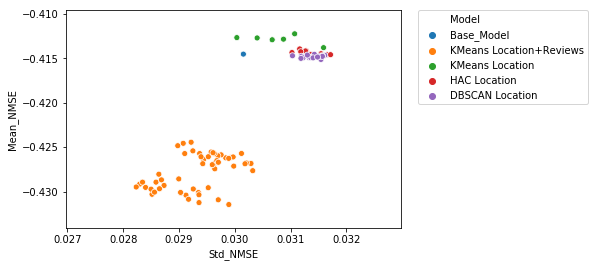

In [120]:
results = pd.DataFrame(columns=['Model','Mean_NMSE','Std_NMSE'])
base = pd.DataFrame(param_base,index=['Model','Mean_NMSE','Std_NMSE']).T
m1 = pd.DataFrame(params,columns=['n_loc','n_review','Mean_NMSE','Std_NMSE'])
m1['Model'] = 'KMeans Location+Reviews'
m2 = pd.DataFrame(params2,columns=['Cluster','Mean_NMSE','Std_NMSE'])
m2['Model'] = 'KMeans Location'
m3 = pd.DataFrame(params3,columns=['n_loc','link','Mean_NMSE','Std_NMSE'])
m3['Model'] = 'HAC Location'
m4 = pd.DataFrame(params4,columns=['Clusters','EPS','mpts','Mean_NMSE','Std_NMSE'])
m4['Model'] = 'DBSCAN Location'

model_compare = pd.concat([results,base,m1[['Model','Mean_NMSE','Std_NMSE']],
                           m2[['Model','Mean_NMSE','Std_NMSE']],
                           m3[['Model','Mean_NMSE','Std_NMSE']],
                           m4[['Model','Mean_NMSE','Std_NMSE']]],
                           axis=0,ignore_index=True)
sns.scatterplot(data=model_compare, x='Std_NMSE',y='Mean_NMSE', hue='Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In the scatterplot above, each point represents the performance of a model, with the accuracy of the model on the y axis and the standard deviation of the accuracy on the x axis. The clustering method is indicated by color, with our base model in blue. The best models (High accuracy, low standard deviation) would be in the top left, where the worst would be in the bottom right.

The combination of location based and review based clustering using kmeans, shown in orange, has some interesting trade offs. It reduces the standard deviation of the mean square error, but does so at the cost of overall accuracy compared to the baseline model.

Agglomerative Clustering and DBSCAN perform about the same, the models they produce overlap heavily in the plot. Overall, they seem to be worse than the baseline model, offering similar accuracy by increased standard deviation. 

Kmeans seemed to perform fairly well, outperforming the accuracy of the baseline model. Most points have higher standard deviation than the baseline, but at least one outperforms in that aspect as well. But is that performance really better than baseline?

In [163]:
nmse_best_kmeans = nmse2[3]

In [167]:
t = 2.26 / np.sqrt(10)

e = nmse_best_kmeans-nmse_base
stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot )
print (np.mean(nmse_best_kmeans), np.mean(nmse_base))

Range of: 0.0015482089943464408 0.01314371546529252
-0.41264988972458133 -0.4199958519544008


The range does not include zero, so the kmeans representation of location does improve our price model in a significant way. Lets double check with a non parametric test.

In [168]:
from scipy.stats import wilcoxon
wilcoxon(nmse_best_kmeans, nmse_base, zero_method='wilcox')

WilcoxonResult(statistic=8.0, pvalue=0.04685328478814715)

The Wilcox test is non-parametric, so if you were uncomfortable with our assumption in the previous test, this could be used. The p-value is below 0.05, so at 95% confidence level we can conclude the two sets of accuracy scores (in this case negative mean square error) come from different distributions.

# Modeling and Evaluation 3	10	
## Visualize Results

Recall, we replaced the latitude, longitude, and neighborhood group variables in our model with cluster labels from various algorithms. We can compare the clustering results to our initial map to see how we might interpret these new clusters. 

In [175]:
maploc = data[['latitude','longitude','neighbourhood_group']]

cls_loc = KMeans(n_clusters=7, init='k-means++',random_state=1,n_jobs=n_jobs)
cls_loc.fit(X1)
maploc['Kmeans_labels'] = cls_loc.labels_.copy()
cls_loc = AgglomerativeClustering(n_clusters=7, linkage='average')
cls_loc.fit(X1)
maploc['HAC_labels'] = cls_loc.labels_.copy()
cls_loc = DBSCAN(eps=0.05, min_samples=14,n_jobs=4)
cls_loc.fit(X1)
maploc['db_labels'] = cls_loc.labels_.copy()

palette1 = sns.color_palette("bright", maploc.neighbourhood_group.nunique())
palette2 = sns.color_palette("bright", maploc.Kmeans_labels.nunique())
palette3 = sns.color_palette("bright", maploc.HAC_labels.nunique())
palette4 = sns.color_palette("bright", maploc.db_labels.nunique())

D:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

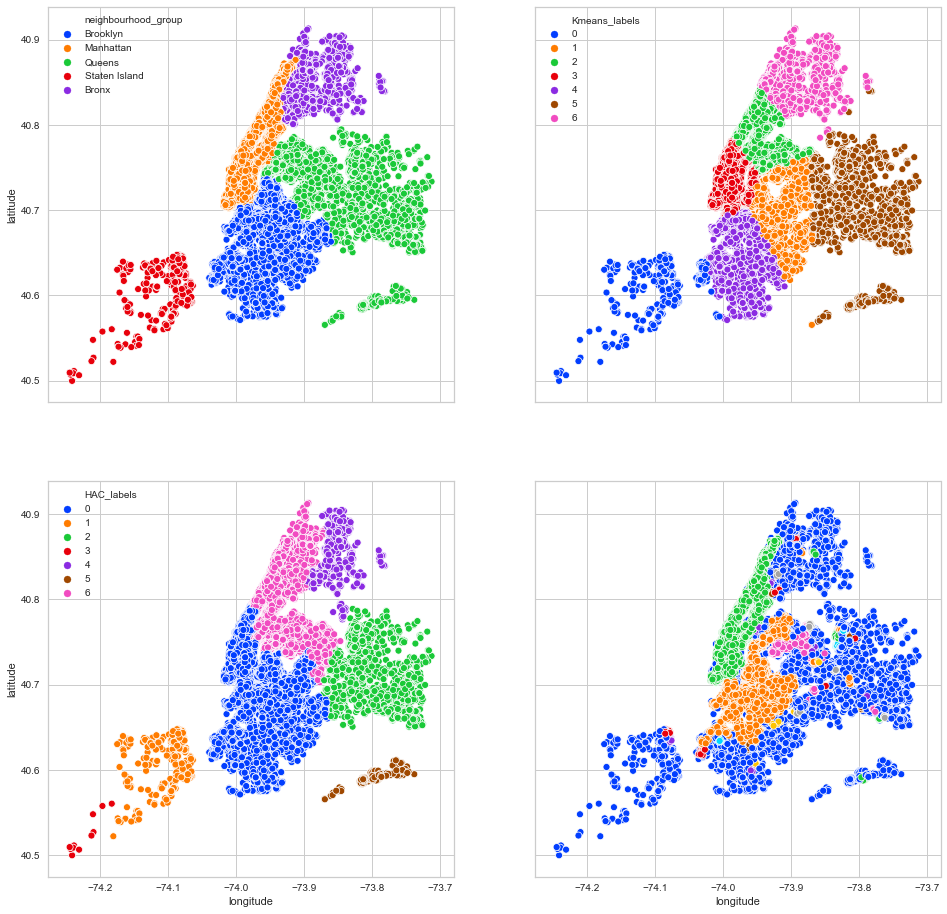

In [178]:
fig, axs = plt.subplots(ncols=2, nrows=2,figsize=[16,16], sharey=True, sharex=True)
sns.scatterplot(x='longitude',y='latitude',hue='neighbourhood_group', data=maploc, ax=axs[0,0], palette=palette1,legend='full')
sns.scatterplot(x='longitude',y='latitude',hue='Kmeans_labels', data=maploc, ax=axs[0,1], palette=palette2,legend='full')
sns.scatterplot(x='longitude',y='latitude',hue='HAC_labels', data=maploc, ax=axs[1,0], palette=palette3,legend='full')
sns.scatterplot(x='longitude',y='latitude',hue='db_labels', data=maploc, ax=axs[1,1], palette=palette4,legend=False)


In the top left, we have the original map. The dots represent listings in 5 NYC neighborhoods. 

In the remaining charts, we have the clusterings with the best model from each cluster. The best model was chosen based on a combination of accuracy and standard deviation of accuracy in cross validation.

In the top right, we have our K means clusters. Kmeans chose 7 clusters over our original 5 groupings. Some notable differences are Manhattan has been split into upper and lower manhattan, and the area between Brooklyn and Queens has become its own area. Perhaps this is useful to our model because of the tourist attractions in lower manhattan and other areas may make the prices higher at these airbnbs.

In the bottom left is Agglomerative Clustering. This model also has 7 clusters. Again Manhattan is split, but this time upper Manhattan has also taken over part of Queens. Staten Island also has a division in its south western area. 

In the bottom right, we see DBSCAN clusters. This model has 57 total clusters, so it's legend is omitted. There are 3 core clusters. The green cluster seems to represent Manhatten (no split this time). The orange one represents sections of Queens and Brooklyn near the river adjacent to Manhattan. The blue seems to represent the outlying areas. This seems to follow the overall listing density show early in Data and Understanding 2.

D:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


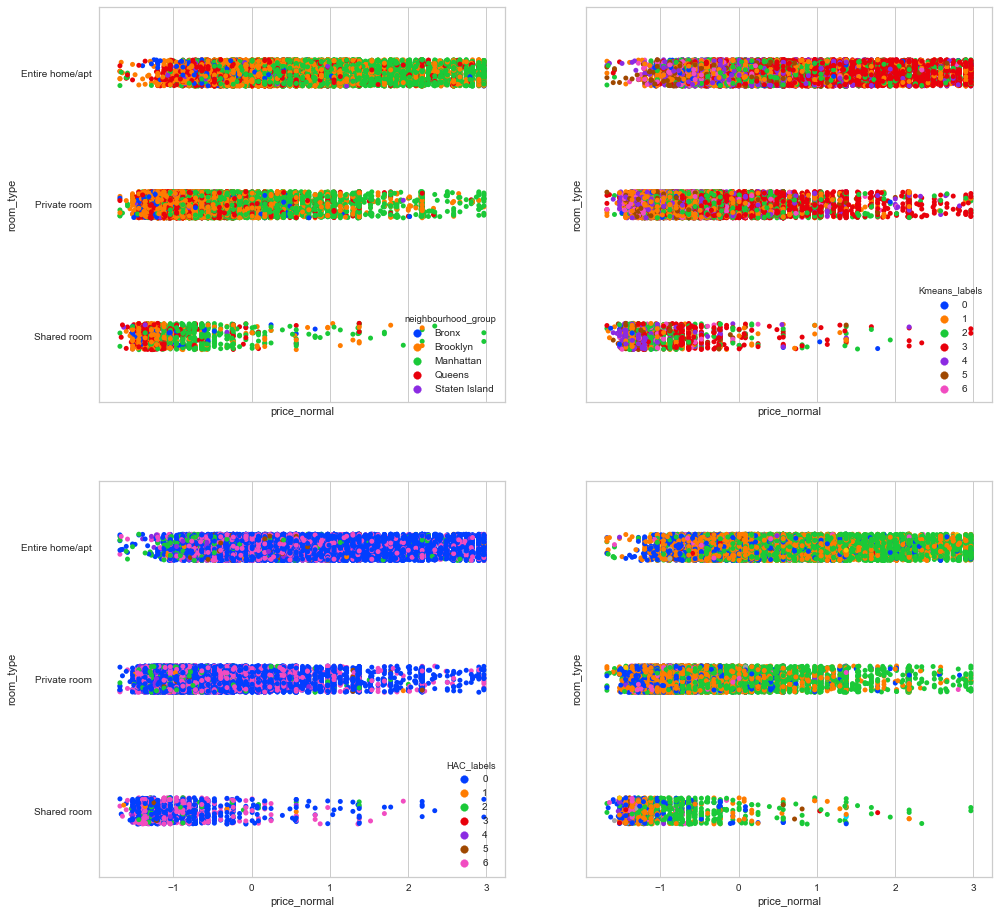

In [205]:
maploc['room_type'] = data['room_type']
maploc['price_normal'] = target

fig, axs = plt.subplots(ncols=2, nrows=2,figsize=[16,16], sharey=True, sharex=True)
sns.stripplot(y='room_type',x='price_normal',hue='neighbourhood_group', data=maploc, ax=axs[0,0], palette=palette1)
sns.stripplot(y='room_type',x='price_normal',hue='Kmeans_labels', data=maploc, ax=axs[0,1], palette=palette2)
sns.stripplot(y='room_type',x='price_normal',hue='HAC_labels', data=maploc, ax=axs[1,0], palette=palette3)
sns.stripplot(y='room_type',x='price_normal',hue='db_labels', data=maploc, ax=axs[1,1], palette=palette4)
legend = axs[1,1].legend()
legend.remove()


In the top left, we can see Manhattan represented at the upper end of price. I would expect to see clusters associated with Manhattan in those ranges as well, and indeed that is the case. Beyond that, it is hard to make out patterns given the density of the points.

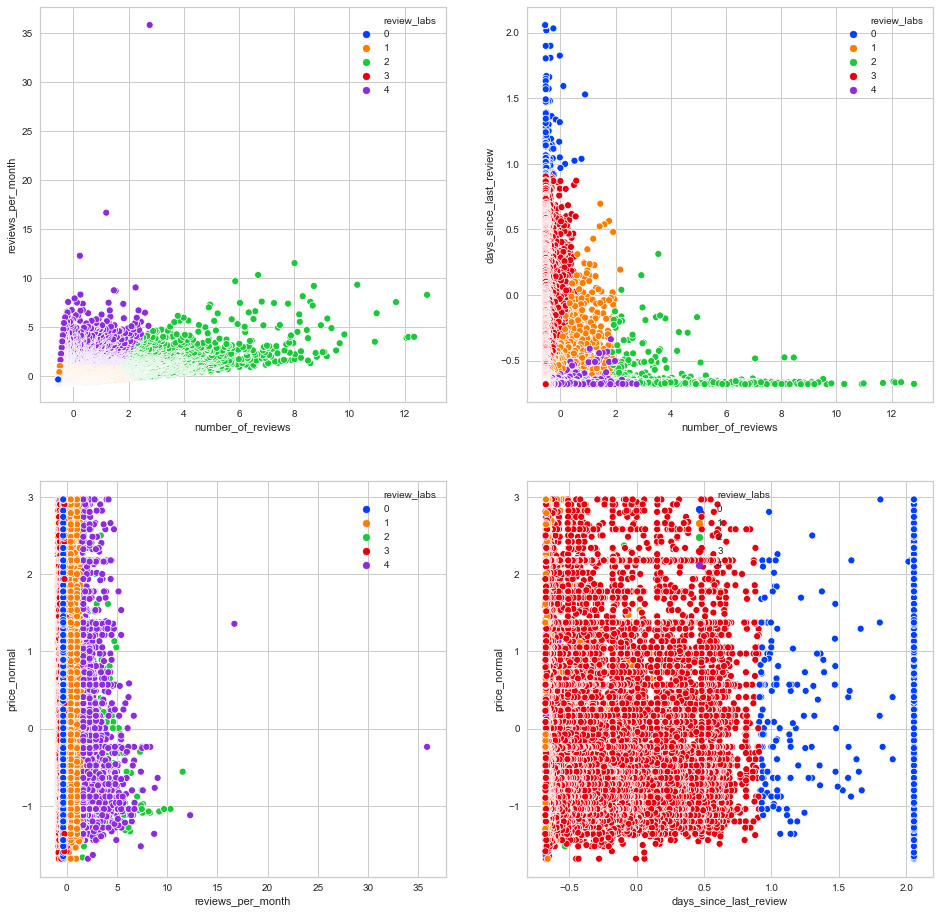

In [214]:
maploc.loc[:,'reviews_per_month'] = data_final['reviews_per_month']
maploc.loc[:,'number_of_reviews'] = data_final['number_of_reviews']
maploc.loc[:,'days_since_last_review'] = data_final['days_since_last_review']
maploc.loc[:,'review_labs'] = review_labs

palette = sns.color_palette("bright", maploc.review_labs.nunique())
fig, axs = plt.subplots(ncols=2, nrows=2,figsize=[16,16])
sns.scatterplot(y='reviews_per_month',x='number_of_reviews',hue='review_labs', data=maploc, ax=axs[0,0],palette=palette)
sns.scatterplot(y='days_since_last_review',x='number_of_reviews',hue='review_labs', data=maploc, ax=axs[0,1],palette=palette)
sns.scatterplot(y='price_normal',x='reviews_per_month',hue='review_labs', data=maploc, ax=axs[1,0],palette=palette)
sns.scatterplot(y='price_normal',x='days_since_last_review',hue='review_labs', data=maploc, ax=axs[1,1],palette=palette)


I wanted to also take a look at reviews. We can see why the model didn't find it useful. In the top two charts you can see the clusters in the review space. When we add price, you can still see some of the clustering along the x axis (reviews), but the clusters seem well distributed across the price axis, so they are not useful in predicting that feature. 

# Modeling and Evaluation 4	20	
## Summarize the Ramifications

Often it is desirable to take continuous predictors and cut them in such a way that reduces the space but preserves information contained in the continuous variable. We explored condensing location and review variables into clusters using KMeans, Agglomerative Clustering, and DBSCAN. 

In terms of our goal of predicting price, location clustering added some value where review clustering did not. Location as a predictor of price makes sense as visitors are likely to be interested in key landmarks and central locations, so demand and therefore price would be higher there. 

Condensing latitude and longitude into a categorical variable had some interesting findings. In many cases we see clusters similar to the neighborhood group, which makes sense if we are using euclidean distance as the distance metric in clustering. However, we also see some neighborhood groups split of mixed, which is likely where our clustering is able to add value. 

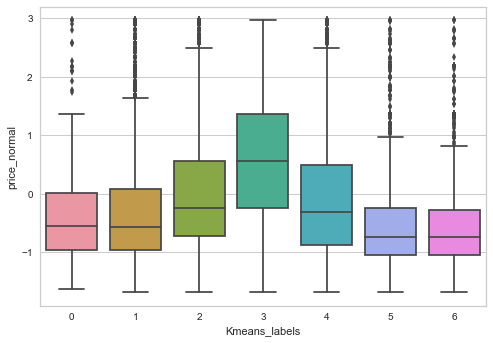

In [215]:
sns.boxplot(x='Kmeans_labels',y='price_normal',data=maploc)

Our Kmeans labeling split Manhattan into upper (cluster 2) and lower (cluster 3). We can see in the boxplot above that there is price differences between those two clusters, which the model may detect easier with this variable rather than using latitude, longitude, and the neighborhood group.

As a result, we are able to improve the negative mean square error from the baseline of -0.420 to -0.413, and the difference is statistically significant.

We will see in the extra work section that location based clustering is also useful for room type classification. There we use spectral clustering to improve the accuracy of our room type model.

Overall, after testing 91 models we found K means with 7 clusters to offer the most improvement. DBSCAN offered some unique insights by clusting central areas together, while Kmeans and Agglomerative Clustering drew new lines between neighborhoods. Clustering can be a powerful new way or exploring relationships in your data.

# Deployment 	10	
## Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

The two features being predicted are price and room type. Price is the price per night the host gave for the listing. Room type for a listing describes the space available to the guest: the entire house or apartment, or a private room in a shared home. The clustering methods were able to successfully improve the performance of the models. They can help capture geographic nuances that are relevant to price and room type. 

Price is a key feature to rental listings and plays a significant role on whether a unit will be rented and in high demand. This feature is useful for prediction for everyone involved with the listing platform for Airbnb. For instance, a host would like to know what factors to consider in order to set the appropriate price for their unit. Their goal is to set the price high enough to generate sufficient income, and low enough to attract prospective tenants. 

Room type is an important feature that categorizes the rental space. This feature is used for prediction because it's helpful to understand the key determinants of price, supply and demand. Private rooms generally lead to a different experience for renters and it's possible Airbnb would want to consider separating this room type from their main platform. This could lead Airbnb to utilize private rooms in a separate offering with an emphasis on the experience. Additional data on the hosts would need to be collected to better understand personality, interests, etc. Furthermore, information related to a shared experience between the tenant and host(s) could be useful to provide more insight into the offering (e.g. shared experience at a nearby museum). Distance to landmarks would be a useful data set to collect in this example.   

The models being employed to predict price and room type can be used to add more value to the platform for Airbnb, hosts, and prospective tenants. Frequency of updates depends on how often new listings are added and could vary by region. In high density areas such as New York, monthly updates to the model would ensure findings are accurate and relevant. A company the size of airbnb likely has either cloud or on premise compute to deploy the model.

# Exceptional Work	10	
## You have free reign to provide additional analyses or combine analyses.

Using the scikit-learn SpectralClustering model we will attempt to add features that improve the prediction power of our room type classifier  

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

## Spectral Decomposition

***Spectral Decomposition Of a Matrix***

Commonly referred to as **eigenvalue decomposition**, spectral decomposition of a matrix is a process that involves factoring a matrix (operator) into canonincal form (i.e represented in terms of its eigenvalues and eigenvectors).  

Solving the general eigenvalue problem:

$({A}-\lambda_{i}{I}){v}_{i,j}=0$
 
Where $\lambda_{i}$ is the diagonal matrix the eigenvalues of the invertable matrix **A**

Solving this system of equations yields set of eigenvectors ${v}_{i,j}$ which form an orthogonal basis for representing the dataset in a reduced space. 

The SpectralClustering class in sklearn has 3 options for computing the eigenvalue decomposition: **arpack**, **lobpcg** and **amg** - we will use the arpack **eigen_solver** to reduce computation time

https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix

Following the procedure outlined [here](https://github.com/jakemdrew/DataMiningNotebooks/blob/master/09.%20Clustering%20and%20Discretization.ipynb) by Dr Drew

- Choose a subset of features from the dataset to cluster upon
- Cluster the features assuming according to a given algorithm
- Replace the features with their discrete cluster labels as a form of discretization
- Perform classification using the new feature from the dataset


## Train and adjust parameters

### Establish Baseline

Baseline classifier will be the best classifier we can create using the following CrossVal/Classification approach:

***Cross Validation***

*Stratified K-Fold Cross Validation (k = 10)*

***Classifier***

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

- **RandomForestClassifier** is an ensemble based method that creates a number of weak estimators (decision trees) based on random samples of data. Each tree correlates to a single vote in the overall voting process where the majority of votes for a particular classification determine the predicted class.

- Compare baseline accuracy to parameter-tuned accuracy for a **RandomForestClassifier**. We will use a default value for max_depth=10 to prevent overfitting.

- We will tune the following parameters:
    - **n_estimators**: *values [80, 90, 100]* the sklearn default is 100 trees/estimators. Each estimator will contribute to the final decision - theoretically, the more estimators, the better the classification - though creating large ensembles is costly from a compute perpective.
    
    - **max_features**: *values [6, 11, 16, 21]* controls the number of features factored into calculating the best split in each node of the estimators created by the model.
    
    - **min_samples_leaf**: *values  [10, 20]* minimum number of samples present in a leaf - higher values prevent overfitting.
    
    - **min_samples_split**: *values  [500, 600, 700]* minimum number of samples present in a split - higher values prevent overfitting.

- We will also run cross validation for multiple scoring metrics (AUC, F1 and Accuracy)

- Additionally, the RF Classifier will give feature importance

In [133]:
data_final = data_final[data_final.Response != 2]
features, target = data_final.drop(
    columns=['Response','room_type_num','room_type_Entire home/apt','room_type_Private room','room_type_Shared room']), data_final.loc[:, ['Response']]
features.shape, target.shape

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=random_state)

latitude was Standard Scaled
longitude was Standard Scaled
price was Standard Scaled
minimum_nights was Standard Scaled
number_of_reviews was Standard Scaled
reviews_per_month was Standard Scaled
calculated_host_listings_count was Standard Scaled
availability_365 was Standard Scaled
dist_subway was Standard Scaled
cnt_all was Standard Scaled
cnt_entire_home was Standard Scaled
cnt_private_room was Standard Scaled
cnt_shared_room was Standard Scaled
avgprice_all was Standard Scaled
avgprice_entire_home was Standard Scaled
avgprice_private_room was Standard Scaled
avgprice_shared_room was Standard Scaled
days_since_last_review was Standard Scaled


latitude                             float64
longitude                            float64
price                                float64
minimum_nights                       float64
number_of_reviews                    float64
reviews_per_month                    float64
calculated_host_listings_count       float64
availability_365                     float64
dist_subway                          float64
cnt_all                              float64
cnt_entire_home                      float64
cnt_private_room                     float64
cnt_shared_room                      float64
avgprice_all                         float64
avgprice_entire_home                 float64
avgprice_private_room                float64
avgprice_shared_room                 float64
days_since_last_review               float64
neighbourhood_group_Bronx              uint8
neighbourhood_group_Brooklyn           uint8
neighbourhood_group_Manhattan          uint8
neighbourhood_group_Queens             uint8
neighbourh

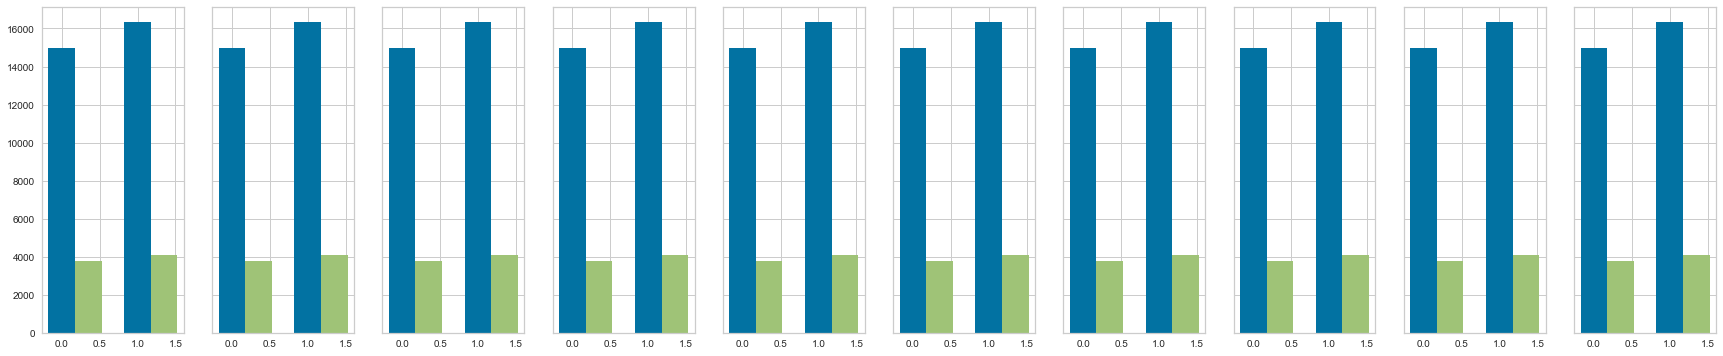

In [134]:
### Cross Validation
n_splits = 10
cv = StratifiedShuffleSplit(n_splits,test_size=.2, train_size=.8, random_state=random_state)
support = []
fold = 0
features_xform = transform_data(features)
fig, ax = plt.subplots(1, n_splits, sharey=True, figsize=(30, 6))
all_train = []
all_test = []
for trainidx, testidx in cv.split(features, target):
    X_train = features_xform.iloc[trainidx] 
    X_test = features_xform.iloc[testidx] 
    y_train = target.iloc[trainidx]
    y_test = target.iloc[testidx]
    classes_test = ClassBalance(labels=['Entire home/apt', 'Private room'], ax=ax[fold])
    classes_test.fit(y_train['Response'], y_test['Response'])
    support.append(classes_test.support_)
    [all_train.append(x) for x in trainidx]
    [all_test.append(x) for x in testidx]
    fold = fold + 1
    
all_train_features = features_xform.iloc[all_train]
all_train_target = target.iloc[all_train]
all_test_features = features_xform.iloc[all_test]
all_test_target = target.iloc[all_test]
features_xform.dtypes

***Hyper Parameter Tuning***

In [135]:
n_estimators= list(range(80, 110, 10))
max_features = list(range(6, len(features_xform.columns), 5))
min_samples_split = list(range(500, 701, 100))
min_samples_leaf = [10, 20]
print(f'n_estimator_grid_search:{n_estimators}')
print(f'max_features_grid_search:{max_features}')
print(f'min_samples_split_grid_search:{min_samples_split}')
print(f'min_samples_leaf_grid_search:{min_samples_leaf}')
scoring = {
            'Accuracy':'accuracy'
            , 'F-1 Score':'f1'
            , 'AUC':'roc_auc'}

n_estimator_grid_search:[80, 90, 100]
max_features_grid_search:[6, 11, 16, 21]
min_samples_split_grid_search:[500, 600, 700]
min_samples_leaf_grid_search:[10, 20]


***Baseline Estimator***

In [138]:
random_forest = RandomForestClassifier(
    n_jobs=-1, # use all processors
    max_depth=10
)
pipe = Pipeline(steps=[('random_forest', random_forest)])
clf_rf_tuned = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {'random_forest__random_state':[random_state],
                                 'random_forest__n_estimators': n_estimators,
                                 'random_forest__min_samples_split': min_samples_split,
                                 'random_forest__max_features': max_features,
                                 'random_forest__min_samples_leaf': min_samples_leaf}
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='AUC'
                   , error_score=0.0)
tuned_rf_fit = clf_rf_tuned.fit(features_xform, target.values.ravel())
print(f'Best Estimator {tuned_rf_fit.best_estimator_}')
pickle.dump(tuned_rf_fit, open('tuned_rf_fit.p', 'wb'))

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  9.0min finished


Best Estimator Pipeline(memory=None,
     steps=[('random_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=500,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=5, verbose=0, warm_start=False))])


***Baseline Accuracy***

In [57]:
classifier = tuned_rf_fit.best_estimator_[0]
acc = cross_val_score(tuned_rf_fit.best_estimator_[0], X_train, y=y_train.values.ravel(), cv=cv)
print(acc)
print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

[0.85714286 0.86400638 0.85219473 0.86161213 0.86256983 0.85171588
 0.86480447 0.85985634 0.85411014 0.8603352 ]
Average accuracy =  85.88347964884278 +- 0.4552972951465257


In [144]:
tuned_rf_fit.best_estimator_

Pipeline(memory=None,
     steps=[('random_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=500,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=5, verbose=0, warm_start=False))])

### Create a new Feature Set With Various Methods of Spectral Clustering
Our first attempt to cluster will be on our geographical variables, **latitude** and **longitude**. We'll start with 5 clusters since there are 5 geographic regions in the NYC area (boroughs). In theory, clustering should reproduce the topography of the city - separating each of the boroughs from one another.

**Affinity Matrix Options**

- ***affinity*** (nearest_neighbor): determines the type affinity/similarity matrix
- ***n_clusters*** (3,4,5,6,7): controls for the number of components selected in the eigenvalue decomposition process



Using the new labels as features for our RandomForestClassifier, we will attempt to improve on the baseline accuracy score of 85.88%

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



Average accuracy = 85.77494014365523+-0.4156664857595138


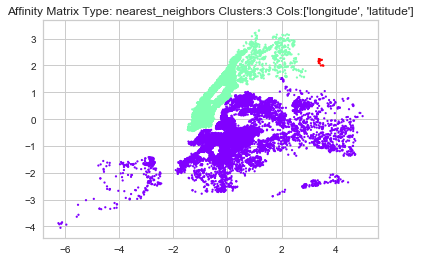

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



Average accuracy = 85.81165203511573+-0.4687658429270117


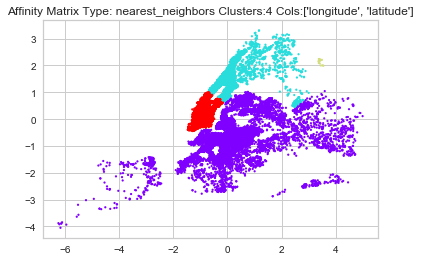

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



Average accuracy = 85.75259377494014+-0.45299720415174477


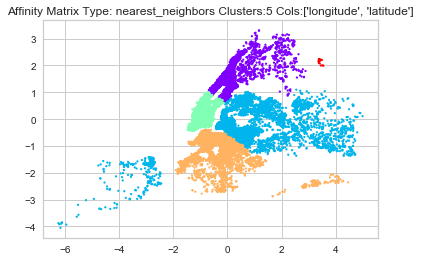

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



Average accuracy = 85.81484437350359+-0.4297846724719936


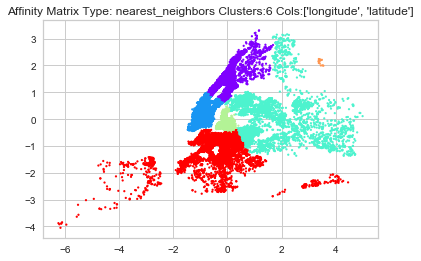

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



Average accuracy = 85.73024740622508+-0.4280591295607152


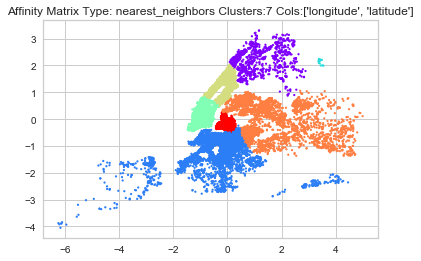

In [180]:
cluster_lat_long_all = run_spectral_clustering(X_train, clusters=[3,4,5,6,7])

As can be seen from the results above, accuracy starts to suffer when the number of clusters transitions from 6 to 7. We will end our tuning process at n_clusters = 7

# Modeling and Evaluation 2	10	

## Evaluate and Compare

#### Baseline Random Forest Classifier:

Our baseline accuracy 85.88% +- 0.46% and was achieved with the following configuration:

    RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=10, max_features=11,
                                            max_leaf_nodes=None, max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=10,
                                            min_samples_split=500,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            oob_score=False, random_state=5,
                                            verbose=0, warm_start=False))
                                            
#### Statistical Effect of Spectral Density Feature Engineering:

## Visualize Results  

From the boxplots below, we can see that if there was any effect on the efficacy of our classification by adding clustering, it was marginal at best. Running a statistical comparison on the cross validation results confirms that if there were any change in accuracy, it was negative (i.e adding clustering did not improve classification ability). In fact, clusters of 5 and 7 were statistically worse than baseline according to the tests.

[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'Clusters'),
 Text(0.5, 1.0, 'Accuracy/Number Of Clusters')]

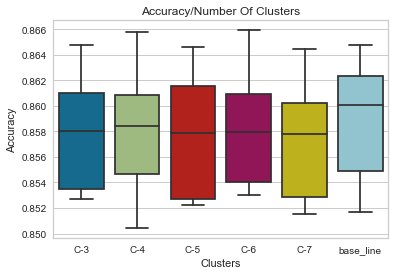

In [209]:
baseline_acc = acc
acc_results = {f'C-{x[1]}':y['results'] for x, y in cluster_lat_long_all.items()}
acc_results.update({'base_line':baseline_acc})
acc_results = pd.DataFrame.from_dict(acc_results, orient='index').T
sns.boxplot(data=acc_results).set(title='Accuracy/Number Of Clusters', ylabel='Accuracy', xlabel='Clusters')

***Run a two sample T-test***

In [221]:
comparisons = []
for x, y in acc_results.items():
    for a, b in acc_results.items():
        if x != a:
            comp = compare_distributions(y, b)
            comp.update({'key':f'{x} to {a}'})
            comparisons.append(comp)

all_comp = pd.DataFrame(comparisons)
sig_comp = all_comp[all_comp.significant == True]
sig_comp

lower     upper    mean_1    mean_2  significant               key
3   0.000121  0.000773  0.857749  0.857302         True        C-3 to C-7
14 -0.002488 -0.000130  0.857526  0.858835         True  C-5 to base_line
18  0.000346  0.001346  0.858148  0.857302         True        C-6 to C-7
20 -0.000773 -0.000121  0.857302  0.857749         True        C-7 to C-3
23 -0.001346 -0.000346  0.857302  0.858148         True        C-7 to C-6
24 -0.002631 -0.000433  0.857302  0.858835         True  C-7 to base_line
27  0.000130  0.002488  0.858835  0.857526         True  base_line to C-5
29  0.000433  0.002631  0.858835  0.857302         True  base_line to C-7

### Feature Importance

From the baseline RandomForestClassifier we can see that **price** is the main driver of room classification. As are the derived metrics of **avgprice_private_room** and **avg_price_entire_home** are also important. All of this is rather intuitive. The higher the price, the more likely a location is to be classified as an 'Entire/Home Apt'. It is also unsurprising that when the average price of Airbnb listings in the area is higher, there is a greater likelihood of the classifier predicting the positive class.

[Text(0.5, 1.0, 'Feature Importance: RF')]

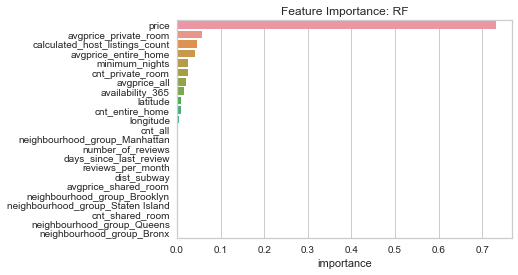

In [210]:
feature_importances = pd.DataFrame(tuned_rf_fit.best_estimator_.steps[0][1].feature_importances_,
                                   index = all_train_features.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

sns.barplot(x="importance", y=feature_importances.index.values, data=feature_importances).set(title='Feature Importance: RF')

***Eigenvectors and Eigenvalues***

Plots of the eigenvectors and eigenvalues derived from the affinity matrices for each run of spectral clustering shows an odd result. All of the affinity matrices appear to have the same eigenvalue/vector structure. **The contributiont to variance are equal across Eigenvectors**

This result seems odd given that the clusters labels are all different for each clustering run. More analysis to be carried out on the resultant affinity matrices created during the spectral density algorithm. **Is there a mathematical reason they are identical?**

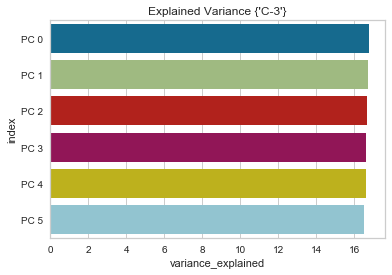

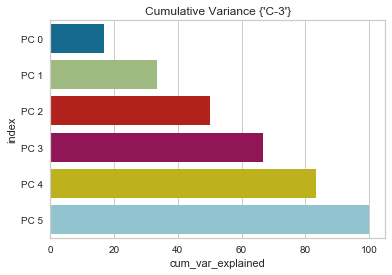

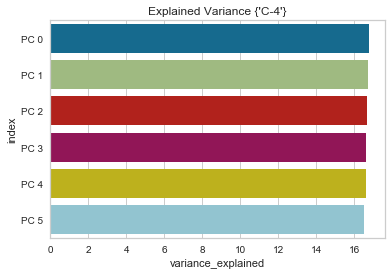

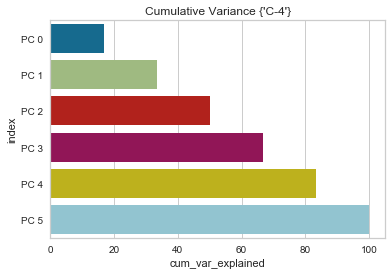

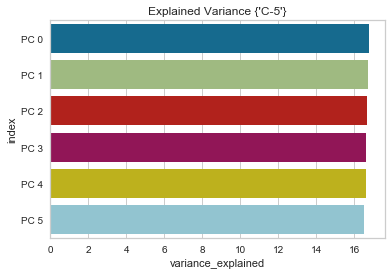

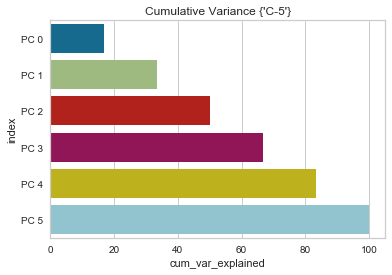

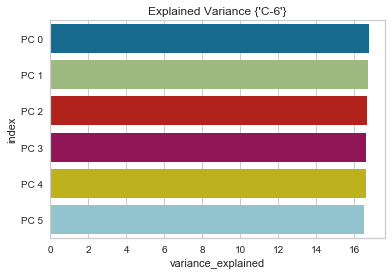

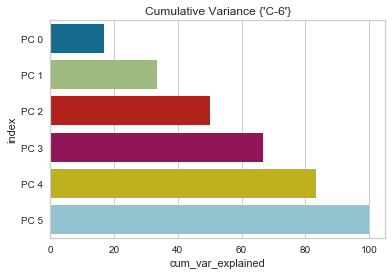

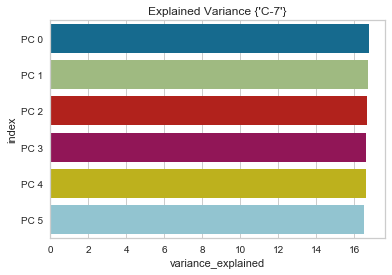

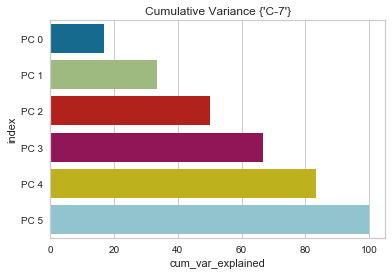

In [254]:
%matplotlib inline
matrices = {f'C-{x[1]}':y['spec_fit'].affinity_matrix_ for x, y in cluster_lat_long_all.items()}
for x, y in matrices.items():
    analyze_eigen_values(y, title={x})

## Summarize the Ramifications

Spectral clustering is a powerful tool for reducing continuous features to subspaces that are more discrete and easier to interpret. Often it is desirable to take continuous predictors and cut them in such a way that reduces the space but preserves information contained in the continuous variable.

In our case, we were able to create a new feature based off of latitude and longitude which closely mapped to the neighbourhood group feature which was already present in the data set - as can be seen by comparing the graphs below. 

While this is not entirely unexpected since the clustering algorithms are based on euclidean distance, it does show that the spectral clustering algorithm was able to create labels which have real world meaning simply by observing the latitude and longitude (the points in space) that it was given. 

### Map Side By Side

Let's compare a geographic map of the NYC area to the labels created in our Spectral Clustering process. Theoretically, we should come fairly close to a geographic mapping of **neighbourhood_group**

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



Average accuracy = 85.75259377494014+-0.45299720415174477


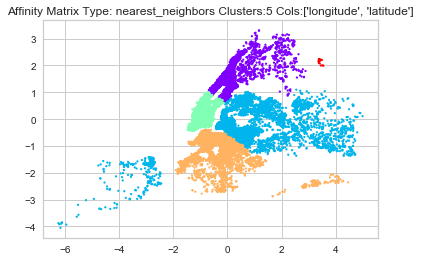

In [283]:
map_data = run_spectral_clustering(X_train, show_map=True)

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



Average accuracy = 85.75259377494014+-0.45299720415174477


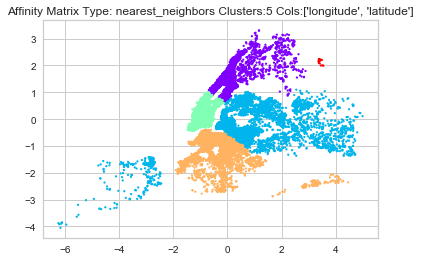

In [283]:
map_data = run_spectral_clustering(X_train, show_map=True)

Further analysis could be undertaken to test out other grid search parameters for Spectral Clustering. Unfortunately, Spectral Clustering is an expensive operation and requires large anounts of training time which makes GridSearchCV a cumbersome process at best. 

It would be interesting to investigate adding our own pre-computed affinity matrices to see if we can improve the speed of the Spectral Clustering algorithm. A signifcant speed boost would allow us to search for more combinations of variables to create derived features (price/distance to subway etc). It is also suggested in the sklearn documentation to use the AMG eigensolver to increase speed, though there were technical difficulties with installing that library.

Although this process did not improve on our base classifier, the fact that it was able to accurately segrate areas of NYC based on lat/long is impressive. Looking at the map of Manhattan in particular - the clustering algorithm appears to have segregated uptown from downtown very well. It would be interesting to investigate why certain parts of Queens (green in the second map) were classified as orange (which is mostly Brooklyn) by the spectral clustering algorithm. 

Further analysis should include spectral clustering on all continuous predictors to create a derived feature set for comparison to the baseline. 

### Deployment

***Be critical of your performance and tell the reader how you current model might be usable by other parties.*** 
    
Ideally, we would've left more time to investigate the various options available for Spectral Clustering as a means for dimensionality reduction. The technique itself would be far more useful if further parameter tuning were undertaken. Of note to anyone else conducting the same analysis, the **numpy eigsh solver** seems to return eigenvectors that all have identical magnitude. 

***Did you achieve your goals?***

Yes and no, while the goal to increase the accuracy of our room type classifier was not met, we discovered a new technique (Spectral Clustering) and were able to abstract it in a way that could be iterated on - for this dataset and others. Ultimately, this code will be more useful than the outcome of our experimental results due to the fact that it established a framework for testing whether or not Spectral Clustering is useful in any scenario. 
    
***If not, can you reign in the utility of your modeling?*** 

Simply iterating further would've allowed us to investigate the true utility of Spectral Clustering. The technique is widely used throughout science and mathematics so there is little doubt that some fine tuning of the parameters in this experiment would yield better results.